In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.utils import resample

In [2]:
df = pd.read_csv('processed_data.csv')
print(df.shape)
# print(df.columns)
df['zip_code'] = df['zip_code'].astype('object')
# print(df.value_counts())
# print(df.dtypes)

(331455, 30)


In [3]:
print(df.shape)
print(df['intime'].value_counts())


(331455, 30)
1    180092
0    151363
Name: intime, dtype: int64


In [34]:
print(df.columns)

Index(['issue_type', 'case_owner', 'city', 'zip_code', 'latitude', 'longitude',
       'method_received', 'sr_priority', 'goal_days', 'not_citizen_pr',
       'lang_spoken_pr', 'civil_emp_pr', 'inc_retirement_pr', 'inc_15_25_pr',
       'poverty_pr', 'hunits_vacant_pr', 'hunits_rental',
       'occupied_hunits_rent_pr', 'aa_pr', 'unemployment_pr', 'fml_emp_pr',
       'fml_inlaborf_pr', 'month', 'intime', 'log_pop', 'log_percapita',
       'log_foreign_pop', 'log_inc_total', 'log_median_rent',
       'log_inc_median'],
      dtype='object')


In [4]:
def corrX_orig(some_data, cut) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = some_data.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()

        
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    # dropcols_idx = drop_set
    dropcols_names = list(some_data.columns[[item for item in drop_set]])
    
    return(dropcols_names)

In [5]:
data = pd.get_dummies(df)

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [6]:
# drop = corrX_orig(data, cut = 0.85)
# data = data.drop(drop, axis =1)
feature_cols =data.columns.drop('intime')

In [7]:
data[feature_cols].shape

(331455, 397)

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.intime))
# n_splits number of reshuffling max 10

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'intime']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'intime']

In [9]:
#scale the features
from sklearn.preprocessing import StandardScaler

# Create an instance of the StandardScaler class
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

(265164, 397)
(265164,)
(66291, 397)
(66291,)


In [11]:
# Create and fit the logistic regression model
from sklearn.linear_model import LogisticRegressionCV
log = LogisticRegressionCV(Cs=10, cv=4, penalty = 'l2', max_iter=10000)
log.fit(X_train_scaled, y_train)

LogisticRegressionCV(cv=4, max_iter=10000)

In [12]:
# Get the mean cross-validated score for each value of C
scores = log.scores_[1].mean(axis=0)

# Print the scores
for C, score in zip(log.Cs_, scores):
    print(f'C: {C:.4f}, mean score: {score:.4f}')

C: 0.0001, mean score: 0.8118
C: 0.0008, mean score: 0.8138
C: 0.0060, mean score: 0.8139
C: 0.0464, mean score: 0.8139
C: 0.3594, mean score: 0.8140
C: 2.7826, mean score: 0.8140
C: 21.5443, mean score: 0.8140
C: 166.8101, mean score: 0.8140
C: 1291.5497, mean score: 0.8140
C: 10000.0000, mean score: 0.8140


In [13]:
# Get the coefficients for each feature
# coefficients = log.coef_[0]

In [14]:
# sorted_features = sorted(zip(data.columns, coefficients), key=lambda x: abs(x[1]), reverse=True)
# # Print the coefficients
# for feature, coef in sorted_features:
#     print(f'{feature}: {coef}')

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Make predictions on the test set
y_pred = log.predict(X_test_scaled)

# Calculate the accuracy
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(accuracy,3)}')
print(f"Precision = {round(precision,3)}")
print(f"Recall = {round(recall,3)}")
print(f"F1 Score = {round(f1score,3)}")

Accuracy: 0.817
Precision = 0.86
Recall = 0.793
F1 Score = 0.825


In [16]:
print(y_pred)

[1 1 0 ... 0 1 1]


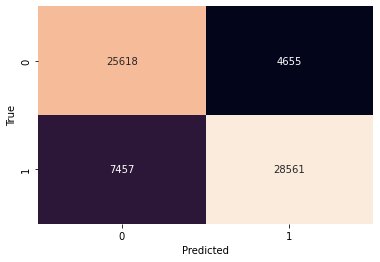

In [52]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# cm = confusion_matrix(y_test, y_pred, labels=[1, 2])

# Create a DataFrame from the confusion matrix
# cm_df = pd.DataFrame(cm, index=[1, 2], columns=[1, 2])

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.show()
plt.savefig("figs/confusion_log.pdf", format="pdf", bbox_inches="tight")




In [18]:
import matplotlib.pyplot as plt

# Fit logistic regression model
model = LogisticRegressionCV(Cs=[2.7826], cv=4, penalty = 'l2',max_iter=10000)
model.fit(X_train_scaled, y_train)

# Get coefficients
coefficients = model.coef_[0]

# Calculate standard errors using bootstrap
n_iterations = 1000
n_size = int(len(X_train_scaled) * 0.50)
coefs = np.zeros((n_iterations, X_train_scaled.shape[1]))
for i in range(n_iterations):
    print(f"iteration:{i}")
    X_sample, y_sample = resample(X_train_scaled, y_train, n_samples=n_size)
    model = LogisticRegressionCV(Cs=[2.7826], cv=4, penalty = 'l2',max_iter=10000)
    model.fit(X_sample, y_sample)
    coefs[i] = model.coef_
se = np.std(coefs, axis=0)

# Sort the coefficients by magnitude
indices = np.argsort(np.abs(coefficients))[::-1]
# print(indices)

# Get the feature names from the column names of the DataFrame
feature_names = list(X_train.columns)

iteration:0
iteration:1
iteration:2
iteration:3
iteration:4
iteration:5
iteration:6
iteration:7
iteration:8
iteration:9
iteration:10
iteration:11
iteration:12
iteration:13
iteration:14
iteration:15
iteration:16
iteration:17
iteration:18
iteration:19
iteration:20
iteration:21
iteration:22
iteration:23
iteration:24
iteration:25
iteration:26
iteration:27
iteration:28
iteration:29
iteration:30
iteration:31
iteration:32
iteration:33
iteration:34
iteration:35
iteration:36
iteration:37
iteration:38
iteration:39
iteration:40
iteration:41
iteration:42
iteration:43
iteration:44
iteration:45
iteration:46
iteration:47
iteration:48
iteration:49
iteration:50
iteration:51
iteration:52
iteration:53
iteration:54
iteration:55
iteration:56
iteration:57
iteration:58
iteration:59
iteration:60
iteration:61
iteration:62
iteration:63
iteration:64
iteration:65
iteration:66
iteration:67
iteration:68
iteration:69
iteration:70
iteration:71
iteration:72
iteration:73
iteration:74
iteration:75
iteration:76
iteration

In [37]:
feature_names = list(X_train.columns)

In [50]:
print(indices[:30])
feature_names[96] = "I:Illegal dumping"
feature_names[48] = "I: Bulky trash r."
feature_names[2] = "Goal days"
feature_names[87] = "I: Garbage C."
feature_names[122] = "I: Pet account u."
feature_names[49] = "I: Bulky trash u."
feature_names[40] = "Iss.: ASU police a."
feature_names[230] = "0: Citations & Tags"
feature_names[164] = "I: Solid Waste a."
feature_names[224] = "I: Cart left out"
feature_names[173] = "I: Community cats"
feature_names[228] = "I: Work w/o permit"
feature_names[28] = "I: Abondened S. carts"
feature_names[91] = "I: Green waste cart r."
feature_names[112] = "I: Mosquito insp."
feature_names[166] = "I: Speed humps"
feature_names[205] = "I: Traffic study"
feature_names[231] = "O: Enf. Sec. 3-36"
feature_names[100] = "I: Injured animal"
feature_names[62] = "I: Unauth. Com. Veh."
feature_names[135] = "I: Recycling c."
feature_names[148] = "I: Sidewalk broken"
feature_names[154] = "I: New Sign-4way"
feature_names[80] = "I: Certificate of use"
feature_names[36] = "I: Dog tag c."
feature_names[235] = "I: Traff. Eng. 10-60"
feature_names[105] = "I: License app."
feature_names[391] = "June"
feature_names[106] = "I: Lost pet"
feature_names[364] = "M: Fax"

[ 96  48   2  87 122  49  40 230 164 224 173 228  28  91 112 166 205 231
 100  62 135 148 154  80  36 235 105 391 106 364]


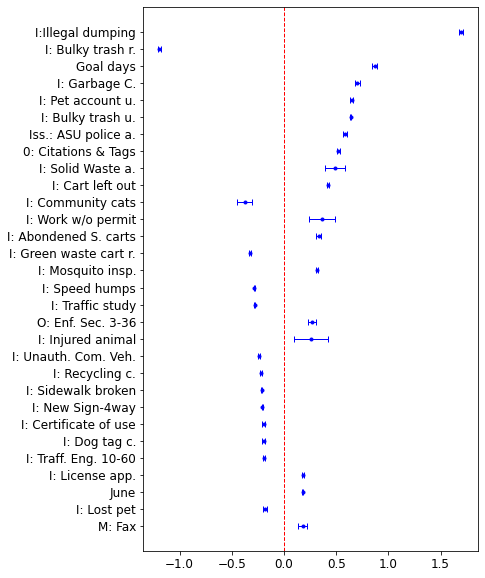

In [51]:
import matplotlib.pyplot as plt

plt.figure()
plt.errorbar(coefficients[indices[:30]], range(29,-1,-1), xerr=se[indices[:30]], fmt='o', color='blue', ecolor='blue', markersize=3, capsize=3, elinewidth=1,markeredgewidth=1)
plt.yticks(range(29,-1,-1), [feature_names[i] for i in indices[:30]],fontsize=12)
plt.xticks(fontsize=12)

# Add vertical line at x=0
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)

plt.gcf().set_figheight(10)

# plt.show()

plt.savefig("figs/coef_log.pdf", format="pdf", bbox_inches="tight")